# Test on whole PE-Header Dataset before Training

In [183]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import multiprocessing
from MalConvGCT_nocat import MalConvGCT
from binaryLoader import BinaryDataset, RandomChunkSampler, pad_collate_func
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, matthews_corrcoef
)

In [195]:
BATCH_SIZE = 64
NUM_CHANNELS = 256
FILTER_SIZE = 256
FILTER_STRIDE = 64
EMBD_SIZE = 8
loader_threads = max(multiprocessing.cpu_count()-4, multiprocessing.cpu_count()//2+1)

# Define the paths to the datasets and the model checkpoint
mal_test_dir = '../datasets/peheaders/Executable Files/Ransomware/rans'
ben_test_dir = '../datasets/peheaders/Executable Files/Goodware/goodware'
model_checkpoint = 'malconvGCT_nocat.checkpoint'

In [196]:
# Load the test dataset
test_dataset = BinaryDataset(ben_test_dir, mal_test_dir, sort_by_size=True, max_len=16000000)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=loader_threads, collate_fn=pad_collate_func, 
                        sampler=RandomChunkSampler(test_dataset,BATCH_SIZE))

# Load the model
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
model = MalConvGCT(channels=NUM_CHANNELS, window_size=FILTER_SIZE, stride=FILTER_STRIDE, embd_size=EMBD_SIZE, low_mem=False).to(device)
model.load_state_dict(torch.load(model_checkpoint)['model_state_dict'], strict=False)
model.eval()

MalConvGCT(
  (pooling): AdaptiveMaxPool1d(output_size=1)
  (cat): CatMod()
  (embd): Embedding(257, 8, padding_idx=0)
  (context_net): MalConvML(
    (pooling): AdaptiveMaxPool1d(output_size=1)
    (cat): CatMod()
    (embd): Embedding(257, 8, padding_idx=0)
    (convs): ModuleList(
      (0): Conv1d(8, 512, kernel_size=(256,), stride=(64,))
    )
    (convs_1): ModuleList(
      (0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
    )
    (fc_1): Linear(in_features=256, out_features=256, bias=True)
    (fc_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (convs): ModuleList(
    (0): Conv1d(8, 512, kernel_size=(256,), stride=(64,))
  )
  (linear_atn): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
  )
  (convs_share): ModuleList(
    (0): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
  )
  (fc_1): Linear(in_features=256, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=2, bias=True)
)

In [197]:
# Evaluate the model
eval_train_correct = 0
eval_train_total = 0

preds = []
truths = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):

        inputs, labels = inputs.to(device), labels.to(device)

        outputs, penultimate_activ, conv_active  = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        preds.extend(F.softmax(outputs, dim=-1).data[:,1].detach().cpu().numpy().ravel())
        truths.extend(labels.detach().cpu().numpy().ravel())
        
        eval_train_total += labels.size(0)
        eval_train_correct += (predicted == labels).sum().item()

# Calculate some metrics
auc = roc_auc_score(truths, preds)
accuracy = accuracy_score(truths, (np.array(preds) > 0.5).astype(int))

print(f'Test AUC: {auc:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

100%|██████████| 34/34 [00:58<00:00,  1.73s/it]

Test AUC: 0.9384
Test Accuracy: 0.8271


In [198]:
# Get the predicted probabilities and predicted classes
predicted_probs = np.array(preds)
predicted_classes = (predicted_probs > 0.5).astype(int).flatten()

# Separate the probabilities into two groups based on the true labels
ransomware_probs = np.array([prob for prob, truth in zip(preds, truths) if truth == 1])
benign_probs = np.array([prob for prob, truth in zip(preds, truths) if truth == 0])

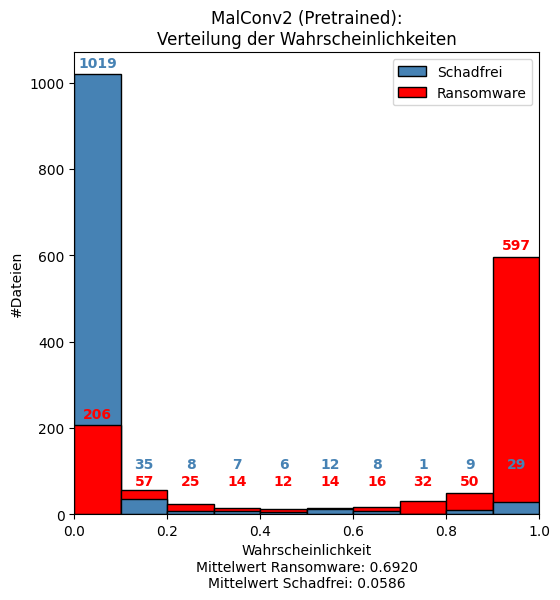

In [199]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Calculate histogram data
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
ransom_hist, _ = np.histogram(ransomware_probs, bins=bins)
benign_hist, _ = np.histogram(benign_probs, bins=bins)

# Determine which histogram has smaller values for each bin
smaller_on_top = ransom_hist < benign_hist

# Plot bars
x = (bins[:-1] + bins[1:]) / 2  # Center of each bin
width = np.diff(bins)

for i in range(len(x)):
    if smaller_on_top[i]:
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
    else:
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')

plt.title('MalConv2 (Pretrained):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

# Add text labels
for i, (ransom_count, benign_count) in enumerate(zip(ransom_hist, benign_hist)):
    if ransom_count < 60:
        plt.text(x[i], 60, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    else:
        plt.text(x[i], ransom_count + 10, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    
    if benign_count < 50:
        plt.text(x[i], 100, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')
    else:
        plt.text(x[i], benign_count + 10, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

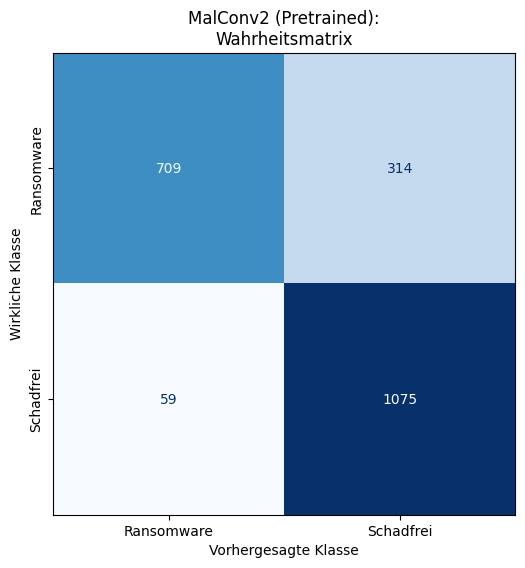

In [200]:
cm = confusion_matrix(truths, predicted_classes)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('MalConv2 (Pretrained):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

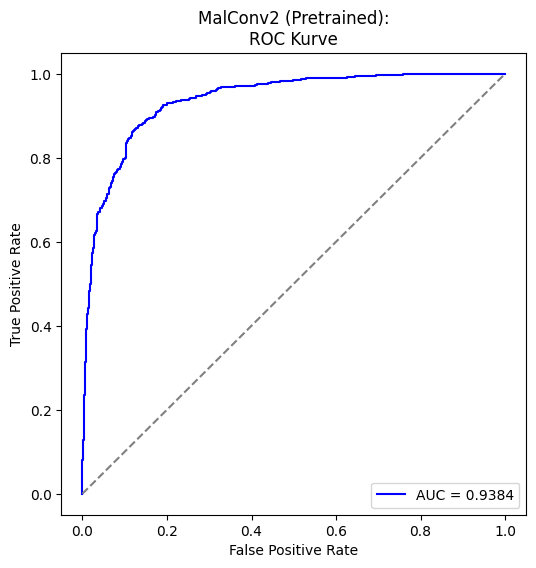

Bester Grenzwert: 0.060540806502103806


In [201]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(truths, predicted_probs)

# Calculate AUC
auc = roc_auc_score(truths, predicted_probs)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MalConv2 (Pretrained):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [202]:
# Calculate and display classification metrics
accuracy = accuracy_score(truths, predicted_classes)
recall = recall_score(truths, predicted_classes)
precision = precision_score(truths, predicted_classes)
f1 = f1_score(truths, predicted_classes)
mcc = (matthews_corrcoef(truths, predicted_classes) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(truths, predicted_classes, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Classification Metrics:
Accuracy: 0.8271
Recall (Sensitivity): 0.6931
Precision: 0.9232
F1-Score: 0.7917
AUC: 0.9384
MCC: 0.8342
Wertung: 0.7660

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.7739    0.9480    0.8522      1134
  Ransomware     0.9232    0.6931    0.7917      1023

    accuracy                         0.8271      2157
   macro avg     0.8486    0.8205    0.8219      2157
weighted avg     0.8447    0.8271    0.8235      2157



# Train on PE-Header Dataset

In [224]:
BATCH_SIZE = 32
NUM_CHANNELS = 128
FILTER_SIZE = 256
FILTER_STRIDE = 64
EMBD_SIZE = 8
loader_threads = max(multiprocessing.cpu_count()-4, multiprocessing.cpu_count()//2+1)

In [225]:
# Load and split the dataset
dataset = BinaryDataset(ben_test_dir, mal_test_dir, sort_by_size=True, max_len=16000000)

dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f'Full dataset size: {dataset_size}, Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}')

Full dataset size: 2157, Train size: 1294, Validation size: 431, Test size: 432


In [227]:
whole_loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=loader_threads, collate_fn=pad_collate_func, 
                        sampler=RandomChunkSampler(dataset,BATCH_SIZE))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=loader_threads, collate_fn=pad_collate_func, 
                        sampler=RandomChunkSampler(train_dataset, BATCH_SIZE))

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=loader_threads, collate_fn=pad_collate_func, 
                        sampler=RandomChunkSampler(val_dataset, BATCH_SIZE))

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=loader_threads, collate_fn=pad_collate_func, 
                        sampler=RandomChunkSampler(test_dataset, BATCH_SIZE))

In [210]:
# Load the model
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
model = MalConvGCT(channels=NUM_CHANNELS, window_size=FILTER_SIZE, stride=FILTER_STRIDE, embd_size=EMBD_SIZE, low_mem=False).to(device)

In [154]:
headers = ['epoch', 'train_acc', 'train_auc', 'val_acc', 'val_auc']

csv_log_out = open('training' + ".csv", 'w')
csv_log_out.write(",".join(headers) + "\n")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

for epoch in tqdm(range(75)):
    
    preds = []
    truths = []
    running_loss = 0.0

    train_correct = 0
    train_total = 0
    
    epoch_stats = {'epoch':epoch}

    model.train()
    for inputs, labels in tqdm(train_loader):
        #Keep inputs on CPU, the model will load chunks of input onto device as needed
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs, penultimate_activ, conv_active = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        
        with torch.no_grad():
            preds.extend(F.softmax(outputs, dim=-1).data[:,1].detach().cpu().numpy().ravel())
            truths.extend(labels.detach().cpu().numpy().ravel())
        
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
    epoch_stats['train_acc'] = train_correct*1.0/train_total
    epoch_stats['train_auc'] = roc_auc_score(truths, preds)
    
    #Save the model and current state!
    model_path = os.path.join('./', "epoch_{}.checkpoint".format(epoch))
    
    mstd = model.state_dict()
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': mstd,
        'optimizer_state_dict': optimizer.state_dict(),
        'channels': NUM_CHANNELS,
        'filter_size': FILTER_SIZE,
        'stride': FILTER_STRIDE,
        'embd_dim': EMBD_SIZE,
        'non_neg': False,
    }, model_path)
    
    
    #Validate Set Eval
    model.eval()
    eval_val_correct = 0
    eval_val_total = 0
    
    preds = []
    truths = []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            outputs, penultimate_activ, conv_active  = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            preds.extend(F.softmax(outputs, dim=-1).data[:,1].detach().cpu().numpy().ravel())
            truths.extend(labels.detach().cpu().numpy().ravel())
            
            eval_val_total += labels.size(0)
            eval_val_correct += (predicted == labels).sum().item()

    epoch_stats['val_acc'] = eval_val_correct*1.0/eval_val_total
    epoch_stats['val_auc'] = roc_auc_score(truths, preds)
    
    csv_log_out.write(",".join([str(epoch_stats[h]) for h in headers]) + "\n")
    csv_log_out.flush()

100%|██████████| 75/75 [3:01:14<00:00, 145.00s/it]


### Find the best Epoch

In [ ]:
aucs = []
accuracies = []

for i in range(40):
    model.load_state_dict(torch.load(f'epoch_{i}.checkpoint')['model_state_dict'], strict=False)
    model.eval()

    # Evaluate the model
    eval_test_correct = 0
    eval_test_total = 0

    preds = []
    truths = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            outputs, penultimate_activ, conv_active  = model(inputs)

            _, predicted = torch.max(outputs.data, 1)

            preds.extend(F.softmax(outputs, dim=-1).data[:,1].detach().cpu().numpy().ravel())
            truths.extend(labels.detach().cpu().numpy().ravel())
            
            eval_test_total += labels.size(0)
            eval_test_correct += (predicted == labels).sum().item()

    # Calculate some metrics
    auc = roc_auc_score(truths, preds)
    aucs.append(auc)

    accuracy = accuracy_score(truths, (np.array(preds) > 0.5).astype(int))
    accuracies.append(accuracy)

# Get the epoch with the best accuracy and AUC
best_acc_epoch = np.argmax(accuracies)
best_auc_epoch = np.argmax(aucs)

print(f'Best Accuracy: {accuracies[best_acc_epoch]:.4f} at epoch {best_acc_epoch}')
print(f'Best AUC: {aucs[best_auc_epoch]:.4f} at epoch {best_auc_epoch}')

100%|██████████| 14/14 [00:32<00:00,  2.32s/it]

Best Accuracy: 0.9491 at epoch 6
Best AUC: 0.9938 at epoch 6


### Evaluate trained Model

In [ ]:
model.load_state_dict(torch.load('epoch_10.checkpoint')['model_state_dict'], strict=False)
model.eval()

MalConvGCT(
  (pooling): AdaptiveMaxPool1d(output_size=1)
  (cat): CatMod()
  (embd): Embedding(257, 8, padding_idx=0)
  (context_net): MalConvML(
    (pooling): AdaptiveMaxPool1d(output_size=1)
    (cat): CatMod()
    (embd): Embedding(257, 8, padding_idx=0)
    (convs): ModuleList(
      (0): Conv1d(8, 256, kernel_size=(256,), stride=(64,))
    )
    (convs_1): ModuleList(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    )
    (fc_1): Linear(in_features=128, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (convs): ModuleList(
    (0): Conv1d(8, 256, kernel_size=(256,), stride=(64,))
  )
  (linear_atn): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (convs_share): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  )
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
# Evaluate the model on the test set
eval_test_correct = 0
eval_test_total = 0

preds = []
truths = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):

        inputs, labels = inputs.to(device), labels.to(device)

        outputs, penultimate_activ, conv_active  = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        preds.extend(F.softmax(outputs, dim=-1).data[:,1].detach().cpu().numpy().ravel())
        truths.extend(labels.detach().cpu().numpy().ravel())
        
        eval_test_total += labels.size(0)
        eval_test_correct += (predicted == labels).sum().item()

# Calculate some metrics
auc = roc_auc_score(truths, preds)
accuracy = accuracy_score(truths, (np.array(preds) > 0.5).astype(int))

# Get the predicted probabilities and predicted classes
predicted_probs = np.array(preds)
predicted_classes = (predicted_probs > 0.5).astype(int).flatten()

# Separate the probabilities into two groups based on the true labels
ransomware_probs = np.array([prob for prob, truth in zip(preds, truths) if truth == 1])
benign_probs = np.array([prob for prob, truth in zip(preds, truths) if truth == 0])

print(f'Test AUC: {auc:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

100%|██████████| 14/14 [00:31<00:00,  2.26s/it]

Test AUC: 0.9998
Test Accuracy: 0.9907


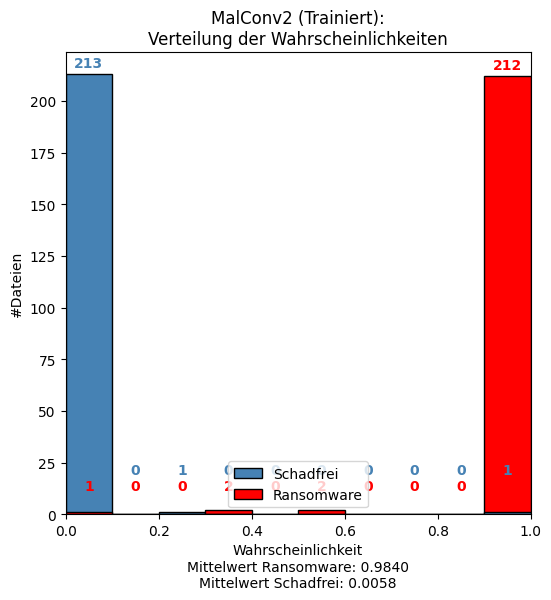

In [ ]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Calculate histogram data
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
ransom_hist, _ = np.histogram(ransomware_probs, bins=bins)
benign_hist, _ = np.histogram(benign_probs, bins=bins)

# Determine which histogram has smaller values for each bin
smaller_on_top = ransom_hist < benign_hist

# Plot bars
x = (bins[:-1] + bins[1:]) / 2  # Center of each bin
width = np.diff(bins)

for i in range(len(x)):
    if smaller_on_top[i]:
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
    else:
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')

plt.title('MalConv2 (Trainiert):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

# Add text labels
for i, (ransom_count, benign_count) in enumerate(zip(ransom_hist, benign_hist)):
    if ransom_count < 60:
        plt.text(x[i], 10, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    else:
        plt.text(x[i], ransom_count + 2, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    
    if benign_count < 50:
        plt.text(x[i], 18, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')
    else:
        plt.text(x[i], benign_count + 2, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

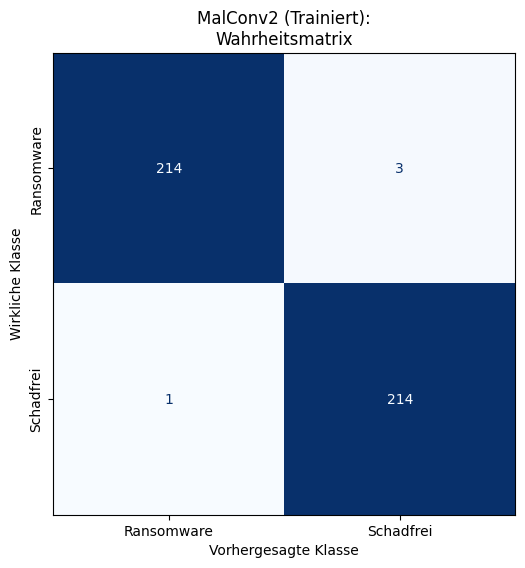

In [ ]:
cm = confusion_matrix(truths, predicted_classes)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('MalConv2 (Trainiert):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

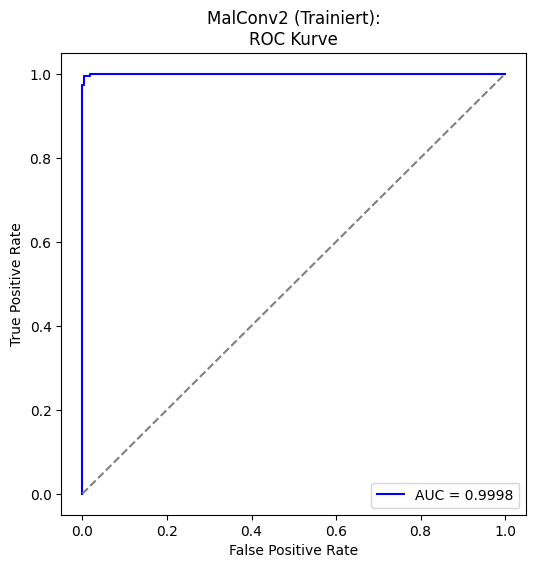

Bester Grenzwert: 0.3389669954776764


In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(truths, predicted_probs)

# Calculate AUC
auc = roc_auc_score(truths, predicted_probs)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MalConv2 (Trainiert):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [ ]:
# Calculate and display classification metrics
accuracy = accuracy_score(truths, predicted_classes)
recall = recall_score(truths, predicted_classes)
precision = precision_score(truths, predicted_classes)
f1 = f1_score(truths, predicted_classes)
mcc = (matthews_corrcoef(truths, predicted_classes) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(truths, predicted_classes, target_names=['Benign', 'Ransomware'], digits=4)

print('Classification Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Classification Metrics:
Accuracy: 0.9907
Recall (Sensitivity): 0.9862
Precision: 0.9953
F1-Score: 0.9907
AUC: 0.9998
MCC: 0.9908
Wertung: 0.9896

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9862    0.9953    0.9907       215
  Ransomware     0.9953    0.9862    0.9907       217

    accuracy                         0.9907       432
   macro avg     0.9908    0.9908    0.9907       432
weighted avg     0.9908    0.9907    0.9907       432



### Evaluate on whole Dataset

In [221]:
model.load_state_dict(torch.load('epoch_10.checkpoint')['model_state_dict'], strict=False)
model.eval()

MalConvGCT(
  (pooling): AdaptiveMaxPool1d(output_size=1)
  (cat): CatMod()
  (embd): Embedding(257, 8, padding_idx=0)
  (context_net): MalConvML(
    (pooling): AdaptiveMaxPool1d(output_size=1)
    (cat): CatMod()
    (embd): Embedding(257, 8, padding_idx=0)
    (convs): ModuleList(
      (0): Conv1d(8, 256, kernel_size=(256,), stride=(64,))
    )
    (convs_1): ModuleList(
      (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    )
    (fc_1): Linear(in_features=128, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (convs): ModuleList(
    (0): Conv1d(8, 256, kernel_size=(256,), stride=(64,))
  )
  (linear_atn): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (convs_share): ModuleList(
    (0): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  )
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=2, bias=True)
)

In [228]:
# Evaluate the model on the test set
eval_test_correct = 0
eval_test_total = 0

preds = []
truths = []
with torch.no_grad():
    for inputs, labels in tqdm(whole_loader):

        inputs, labels = inputs.to(device), labels.to(device)

        outputs, penultimate_activ, conv_active  = model(inputs)

        _, predicted = torch.max(outputs.data, 1)

        preds.extend(F.softmax(outputs, dim=-1).data[:,1].detach().cpu().numpy().ravel())
        truths.extend(labels.detach().cpu().numpy().ravel())
        
        eval_test_total += labels.size(0)
        eval_test_correct += (predicted == labels).sum().item()

# Calculate some metrics
auc = roc_auc_score(truths, preds)
accuracy = accuracy_score(truths, (np.array(preds) > 0.5).astype(int))

# Get the predicted probabilities and predicted classes
predicted_probs = np.array(preds)
predicted_classes = (predicted_probs > 0.5).astype(int).flatten()

# Separate the probabilities into two groups based on the true labels
ransomware_probs = np.array([prob for prob, truth in zip(preds, truths) if truth == 1])
benign_probs = np.array([prob for prob, truth in zip(preds, truths) if truth == 0])

print(f'AUC: {auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')

100%|██████████| 68/68 [00:32<00:00,  2.09it/s]

AUC: 0.9992
Accuracy: 0.9847


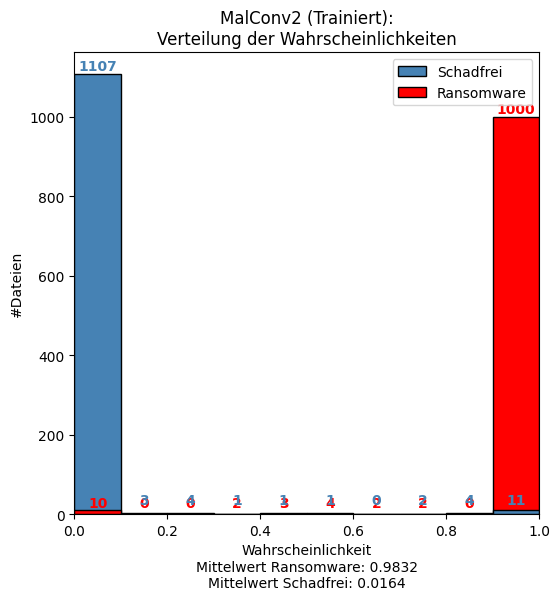

In [229]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Calculate histogram data
bins = np.linspace(0, 1, 11)  # 10 bins from 0 to 1
ransom_hist, _ = np.histogram(ransomware_probs, bins=bins)
benign_hist, _ = np.histogram(benign_probs, bins=bins)

# Determine which histogram has smaller values for each bin
smaller_on_top = ransom_hist < benign_hist

# Plot bars
x = (bins[:-1] + bins[1:]) / 2  # Center of each bin
width = np.diff(bins)

for i in range(len(x)):
    if smaller_on_top[i]:
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
    else:
        plt.bar(x[i], ransom_hist[i], width[i], color='red', edgecolor='black', label='Ransomware' if i == 0 else '')
        plt.bar(x[i], benign_hist[i], width[i], color='steelblue', edgecolor='black', label='Schadfrei' if i == 0 else '')

plt.title('MalConv2 (Trainiert):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')

# Add text labels
for i, (ransom_count, benign_count) in enumerate(zip(ransom_hist, benign_hist)):
    if ransom_count < 60:
        plt.text(x[i], 10, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    else:
        plt.text(x[i], ransom_count + 2, f'{int(ransom_count)}', ha='center', va='bottom', color='red', fontweight='bold')
    
    if benign_count < 50:
        plt.text(x[i], 18, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')
    else:
        plt.text(x[i], benign_count + 2, f'{int(benign_count)}', ha='center', va='bottom', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

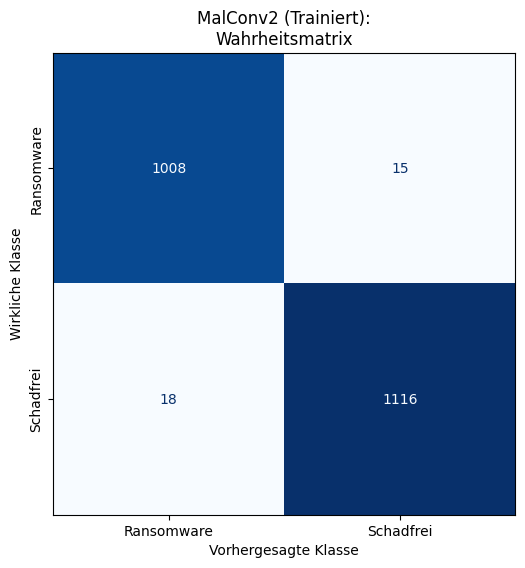

In [230]:
cm = confusion_matrix(truths, predicted_classes)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('MalConv2 (Trainiert):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

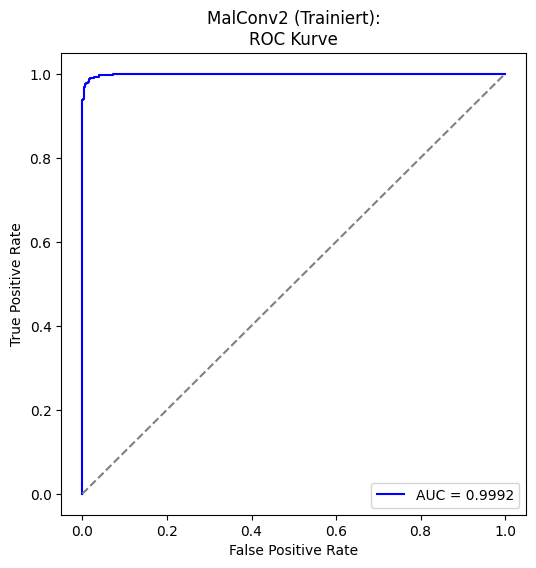

Bester Grenzwert: 0.3389669954776764


In [231]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(truths, predicted_probs)

# Calculate AUC
auc = roc_auc_score(truths, predicted_probs)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MalConv2 (Trainiert):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [233]:
# Calculate and display classification metrics
accuracy = accuracy_score(truths, predicted_classes)
recall = recall_score(truths, predicted_classes)
precision = precision_score(truths, predicted_classes)
f1 = f1_score(truths, predicted_classes)
mcc = (matthews_corrcoef(truths, predicted_classes) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(truths, predicted_classes, target_names=['Benign', 'Ransomware'], digits=4)

print('Classification Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Classification Metrics:
Accuracy: 0.9847
Recall (Sensitivity): 0.9853
Precision: 0.9825
F1-Score: 0.9839
AUC: 0.9992
MCC: 0.9847
Wertung: 0.9866

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9867    0.9841    0.9854      1134
  Ransomware     0.9825    0.9853    0.9839      1023

    accuracy                         0.9847      2157
   macro avg     0.9846    0.9847    0.9847      2157
weighted avg     0.9847    0.9847    0.9847      2157

